In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm
import pylab as py
import random
import math

In [2]:
ticker = pd.read_csv("/Users/austinriis-due/Documents/GitHub/energy_analytics/SPY.csv")

In [3]:
ticker

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-10-30,303.429993,304.549988,301.989990,304.140015,298.370117,49643900
1,2019-10-31,304.130005,304.130005,301.730011,303.329987,297.575439,69053800
2,2019-11-01,304.920013,306.190002,304.739990,306.140015,300.332184,71141500
3,2019-11-04,307.850006,308.000000,306.959991,307.369995,301.538818,60606900
4,2019-11-05,307.589996,307.920013,306.709991,307.029999,301.205261,42933200
...,...,...,...,...,...,...,...
248,2020-10-23,345.929993,345.989990,343.130005,345.779999,345.779999,49143900
249,2020-10-26,342.130005,342.980011,335.619995,339.390015,339.390015,91473000
250,2020-10-27,339.760010,340.119995,337.989990,338.220001,338.220001,65994100
251,2020-10-28,332.100006,338.250000,326.130005,326.660004,326.660004,127094300


In [4]:
#adding daily returns column close to close
r = [0]
i = 1
while i < len(ticker.Close):
    s = (ticker.Close[i] / ticker.Close[i-1])-1
    r.append(s)
    i+= 1
r[0] = sum(r)/len(r) #no data before row 0; inserted average
ticker["Returns"] = r
ticker.Returns.describe()

count    253.000000
mean       0.000544
std        0.020874
min       -0.109424
25%       -0.005513
50%        0.002128
75%        0.008619
max        0.090603
Name: Returns, dtype: float64

In [5]:
# daily deviation from mean
devObs = abs(ticker["Returns"] - ticker.Returns.mean())
ticker["devObs"] = devObs
ticker.devObs.describe()

count    253.000000
mean       0.012641
std        0.016592
min        0.000002
25%        0.003121
50%        0.007105
75%        0.014760
max        0.109967
Name: devObs, dtype: float64

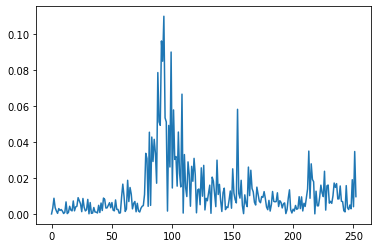

In [6]:
#plotting daily volatilities
fig, ax = plt.subplots(1, 1)
ax.plot(ticker.devObs)

In [7]:
# fitting theta parameter
t = (((ticker.devObs.std())**2))/ticker.devObs.mean()
t

0.021777513951596016

## Basic Monte Carlo Simulation

In [8]:
# fitting alpha parameter
a = ticker.devObs.mean()/t
a

0.5804819442570374

In [9]:
# sanity check
print(a*t)

0.012641453639707211


In [10]:
# monte carlo sim from gamma distribution
def getVol(alpha, theta):
    u = random.uniform(0,1)
    return(st.gamma.ppf(u,a=alpha,scale = theta))

In [11]:
# sanity check 
getVol(a,t)

0.043346317720622106

In [12]:
#monte carlo sim for returns and price formula
def getPrice(s_0,mu,divs, alpha, theta):
    sigma = getVol(alpha, theta)
    u = random.uniform(0,1)
    Z = st.norm.ppf(u)
    return(s_0*math.exp(mu - divs-(.5*(sigma**2))+sigma*Z))

In [13]:
#test for 2 day paths based on last close price *non stratified*
s1 = [getPrice(s_0 = ticker.Close[251],mu = ticker["Returns"].mean(),divs = 0,alpha = a,theta = t) for x in range(1000000)]
s2 = [getPrice(s_0 = v,mu = ticker["Returns"].mean(),divs = 0,alpha = a,theta = t) for v in s1]

In [14]:
# day one test stats
pd.Series(s1).describe()

count    1000000.000000
mean         326.841534
std            6.815107
min          166.279335
25%          325.715378
50%          326.837505
75%          327.912785
max          534.868571
dtype: float64

In [15]:
#day two test stats
pd.Series(s2).describe()

count    1000000.000000
mean         327.016035
std            9.652229
min          163.072020
25%          324.118054
50%          327.001469
75%          329.780476
max          537.221370
dtype: float64

(array([3.00000e+00, 2.80000e+01, 6.10000e+02, 2.72370e+04, 9.63552e+05,
        8.12300e+03, 3.97000e+02, 4.10000e+01, 7.00000e+00, 2.00000e+00]),
 array([166.27933522, 203.1382588 , 239.99718238, 276.85610596,
        313.71502954, 350.57395312, 387.43287671, 424.29180029,
        461.15072387, 498.00964745, 534.86857103]),
 <a list of 10 Patch objects>)

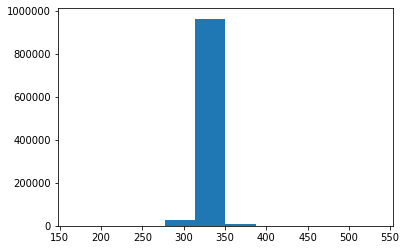

In [16]:
#day one histogram
plt.hist(s1)

(array([5.00000e+00, 4.60000e+01, 1.25300e+03, 4.81400e+04, 9.30948e+05,
        1.85530e+04, 9.51000e+02, 8.70000e+01, 1.40000e+01, 3.00000e+00]),
 array([163.07202037, 200.48695531, 237.90189025, 275.31682519,
        312.73176013, 350.14669507, 387.56163001, 424.97656495,
        462.39149989, 499.80643482, 537.22136976]),
 <a list of 10 Patch objects>)

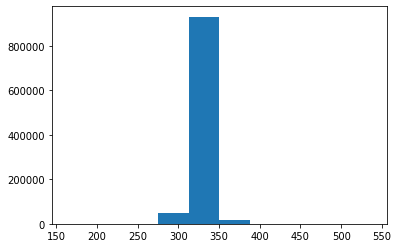

In [17]:
#day two histogram
plt.hist(s2)

## Graphical Analyses and Stress Tests

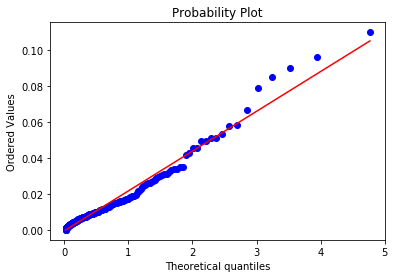

In [18]:
# probability plot of gamma against data
fig, ax = plt.subplots(1, 1)
st.probplot(ticker.devObs.sort_values(), sparams = (a,t),plot = ax,dist = 'gamma')
plt.show()

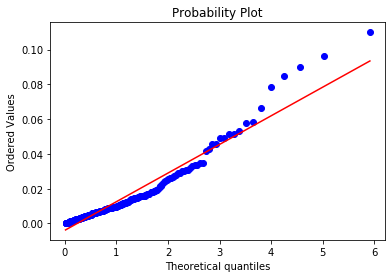

In [19]:
# probability plot of exponential against data
fig, ax = plt.subplots(1, 1)
st.probplot(ticker.devObs.sort_values(), sparams = (1,ticker.devObs.mean()),plot = ax,dist = 'gamma')
plt.show()

In [20]:
# likelihood ratio test to see if exponential is better fit for volatility
Lgam = [math.log(st.gamma.pdf(x,a=a,scale=t)) for x in ticker.devObs]
Lexp = [math.log(st.gamma.pdf(x,a = 1, scale = ticker.devObs.mean())) for x in ticker.devObs]

In [21]:
def loglikelihood(list):
    s = 0
    for i in list:
        s+=i
    return s

In [22]:
test_stat = 2*((loglikelihood(Lexp)-math.log(253)) - (loglikelihood(Lgam)-.5*math.log(253)))
test_stat 
# if fail to reject on 1 degree of freedom use gamma

6.257931100555197

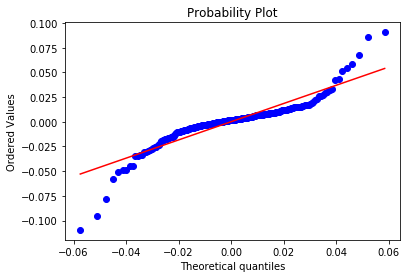

In [23]:
# probability plot of returns against data
# should have heavy tail indicator
fig, ax = plt.subplots(1, 1)
st.probplot(ticker.Returns.sort_values(), sparams = (ticker.Returns.mean(),ticker.Returns.std()),plot = ax,dist = 'norm')
plt.show()

In [24]:
#monte carlo for returns
def getReturns(mu,sigma,l,u):
    q = random.uniform(l,u)
    return st.norm.ppf(q,loc = mu, scale = sigma)

(array([ 2.,  3., 13., 40., 56., 64., 43., 19., 10.,  3.]),
 array([-0.04080422, -0.03286194, -0.02491965, -0.01697736, -0.00903507,
        -0.00109279,  0.0068495 ,  0.01479179,  0.02273408,  0.03067637,
         0.03861865]),
 <a list of 10 Patch objects>)

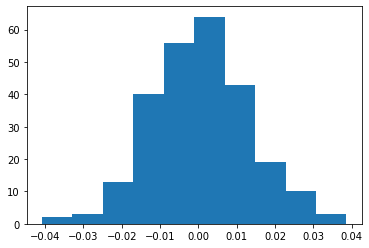

In [25]:
# test for returns
j = h = 1/len(ticker.Returns)
i = 0
test = []
while j < 1:
    x = [getReturns(mu = ticker.Returns.mean(), sigma = getVol(a,t),l = i, u = j) for x in range(100)]
    test.append(sum(x)/len(x))
    i += h
    j += h
plt.hist(test)

(array([  2.,   1.,   2.,  11.,  28., 161.,  38.,   4.,   4.,   2.]),
 array([-0.10942373, -0.08942104, -0.06941834, -0.04941564, -0.02941294,
        -0.00941024,  0.01059246,  0.03059516,  0.05059786,  0.07060056,
         0.09060326]),
 <a list of 10 Patch objects>)

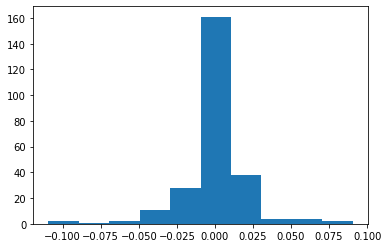

In [26]:
plt.hist(ticker.Returns)

In [27]:
st.ttest_ind(pd.Series(ticker.Returns).sort_values(),pd.Series(test).sort_values())

Ttest_indResult(statistic=-0.01448434458272085, pvalue=0.9884493009007345)

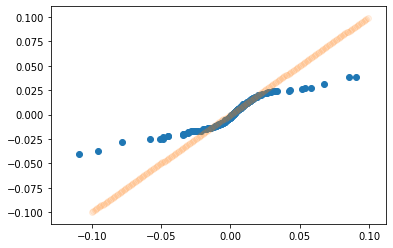

In [28]:
# qq plot for returns
# should indicate heavy tails
plt.scatter(pd.Series(ticker.Returns).sort_values(),pd.Series(test).sort_values())
plt.scatter([x/1000 for x in range(-100,100)],[x/1000 for x in range(-100,100)], alpha = .1)

(array([164.,  45.,  21.,  11.,   5.,   3.,   2.,   1.,   0.,   1.]),
 array([4.77515087e-07, 1.16622991e-02, 2.33241208e-02, 3.49859424e-02,
        4.66477640e-02, 5.83095857e-02, 6.99714073e-02, 8.16332289e-02,
        9.32950506e-02, 1.04956872e-01, 1.16618694e-01]),
 <a list of 10 Patch objects>)

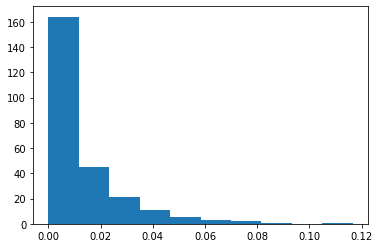

In [29]:
#Checking Stratified Volatility
def getVolStrata(alpha, theta,l,u):
    u = random.uniform(l,u)
    return(st.gamma.ppf(u,a=alpha,scale = theta))

j = h = 1/len(ticker.devObs)
i = 0
test = []
while j < 1:
    x = [getVolStrata(a,t,l = i, u = j) for x in range(100)]
    test.append(sum(x)/len(x))
    i += h
    j += h
plt.hist(test)

In [30]:
st.ttest_ind(pd.Series(ticker.devObs).sort_values(),pd.Series(test).sort_values())

Ttest_indResult(statistic=-0.00043293837929774323, pvalue=0.9996547364662356)

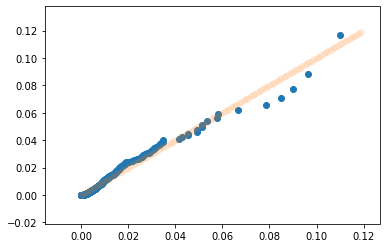

In [31]:
plt.scatter(pd.Series(ticker.devObs).sort_values(),pd.Series(test).sort_values())
plt.scatter([x/1000 for x in range(0,120)],[x/1000 for x in range(0,120)], alpha = .1)

## Stratified Monte Carlo Modeling

In [32]:
# Stratified volatility sampling
def getVolStrata(alpha, theta,l,u):
    u = random.uniform(l,u)
    return(st.gamma.ppf(u,a=alpha,scale = theta))

In [33]:
# Stratified price sampling
def getPriceStrata(s_0,mu,divs, alpha, theta,low,up,bottom,top):
    sigma = getVolStrata(alpha, theta,bottom,top)
    u = random.uniform(low,up)
    Z = st.norm.ppf(u)
    return(s_0*math.exp(mu - divs-(.5*(sigma**2))+sigma*Z))

In [34]:
# Stratified paths for next day
s1 = []
l = 0
u = .001
y = 0
z = .001
h = .001
while round(u,6) <= 1:
    while round(z,6) <= 1:
        s1.append(getPriceStrata(s_0 = ticker.Close[252],mu = ticker["Returns"].mean(),divs = 0,alpha = a,theta = t, low = l, up = u, bottom = y, top = z))
        y += h
        z += h
    l += h
    u += h
    y = 0
    z = .001

pd.Series(s1).describe()

count    1000000.000000
mean         330.159278
std            6.893754
min          181.240614
25%          329.024957
50%          330.159263
75%          331.243566
max          532.184004
dtype: float64

(array([4.00000e+00, 5.60000e+01, 1.15400e+03, 5.29060e+04, 9.39178e+05,
        6.23400e+03, 4.05000e+02, 5.30000e+01, 6.00000e+00, 4.00000e+00]),
 array([181.24061431, 216.33495331, 251.4292923 , 286.5236313 ,
        321.6179703 , 356.71230929, 391.80664829, 426.90098729,
        461.99532628, 497.08966528, 532.18400428]),
 <a list of 10 Patch objects>)

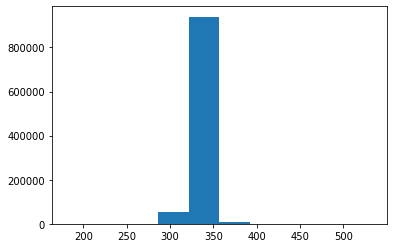

In [35]:
plt.hist(s1)

In [36]:
# Put Payoff Function
def PutPayoff(pricesT, k):
    PutPayoff = []
    for x in pricesT:
        if k-x>0:
            PutPayoff.append(k-x)
        else:
            PutPayoff.append(0)
    return pd.Series(PutPayoff)

In [37]:
# Call Payoff Function
def CallPayoff(pricesT, k):
    CallPayoff = []
    for x in pricesT:
        if x-k>0:
            CallPayoff.append(x-k)
        else:
            CallPayoff.append(0)
    return pd.Series(CallPayoff)

In [38]:
# Prices for any number of days 
# Based on initial path calculated above
def PriceIt(Stop, s_0):
    days = 0
    while days < Stop:
        s_New = []
        l = 0
        u = .001
        y = 0
        z = .001
        h = .001
        for s in s_0:
            while round(u,6) <= 1:
                while round(z,6) <= 1:
                    s_New.append(getPriceStrata(s_0 = s,mu = ticker["Returns"].mean(),divs = 0,alpha = a,theta = t, low = l, up = u, bottom = y, top = z))
                    y += h
                    z += h
                l += h
                u += h
                y = 0
                z = .001
        s_0 = s_New
        days += 1
    return pd.Series(s_New)

In [39]:
# Gives probability of jump to a loss for a put with given strike
# on day that series refers to
def getStrikePrLossPut(strike, series):
    series = pd.Series(series)
    for price in list(series.sort_values()):
        if price >= strike:
            return 1-(list(series.sort_values()).index(price)/len(list(series.sort_values())))
    return list(series.sort_values())[-1]

In [40]:
# Gives probability of jump to a loss for a call with given strike
# on day that series refers to
def getStrikePrLossCall(strike, series):
    series = pd.Series(series)
    for price in list(series.sort_values()):
        if price >= strike:
            return (list(series.sort_values()).index(price)/len(list(series.sort_values())))
    return list(series.sort_values())[-1]

In [41]:
# stratified pathwise monte carlo runs
# tomorrow is s1
# next day is based on s1
# mon = PriceIt(1,s1)
# tues = PriceIt(1,mon)
# wed = PriceIt(1,tues)
# th = PriceIt(1,wed)
# fr = PriceIt(1,th)

In [42]:
1- getStrikePrLossPut(340,s1)

0.956021